In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os 

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes
from amfe.units import convert




Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using python in global path


In [2]:
mesh_folder = '/home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes'
msh_name = r'3D_safran_tet4_disk_1661_nodes_with_name_selections.inp'
msh_file = os.path.join(mesh_folder,msh_name)
m = amfe.Mesh()
m.import_inp(msh_file,1000)

*************************************************************

Loading Abaqus-mesh from /home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes/3D_safran_tet4_disk_1661_nodes_with_name_selections.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh /home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes/3D_safran_tet4_disk_1661_nodes_with_name_selections.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


In [3]:
from pyfeti import utils
utils.save_object(m,'disk.pkl')

<IPython.core.display.Javascript object>


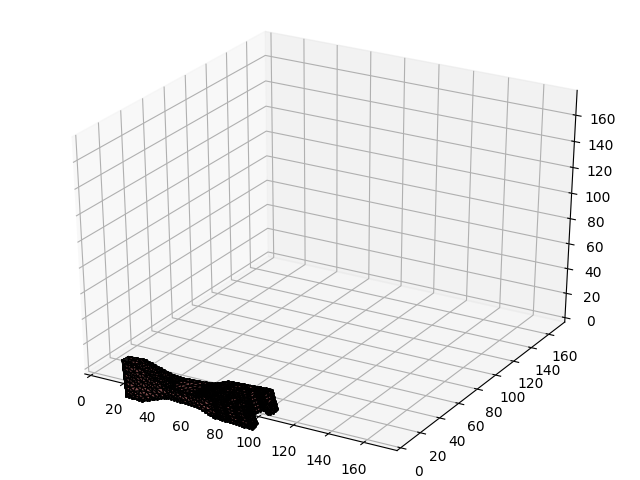

(0, 175)

In [4]:
ax1 = amfe.plot3Dmesh(m)
#pltmesh.show(plot_nodes=False)
vlim=[0,175]
ax1.set_xlim(vlim)
ax1.set_ylim(vlim)
ax1.set_zlim(vlim)
#pltmesh.set_equal_axis_lim(vlim)

In [5]:
print(m.get_elem_types())
print(m.get_phys_group_types())

{'Tet4', 'Tri3'}
{'DISC_1_6_SOLID_ELSET', 'DISC_1_2_ELSET', 'DISC_1_1_SOLID_ELSET', 'DISC_1_6_ELSET', 'DISC_1_3_ELSET', 'FRONT_FACE_ELSET', 'DISC_1_3_SOLID_ELSET', 'DISC_1_1_ELSET', 'DISC_1_4_SOLID_ELSET', 'BACK_FACE_ELSET', 'DISC_1_5_SOLID_ELSET', 'SHAFT_FACE_ELSET', 'DISC_1_4_ELSET', 'DISC_1_2_SOLID_ELSET', 'DISC_1_5_ELSET'}


In [6]:
map_string = lambda  i : 'DISC_1_%i_SOLID_ELSET' %i

# rename solid components

for i in range(1,7):
    m.change_tag_in_eldf('phys_group',map_string(i),'DISK')


In [7]:
print(m.get_phys_group_types())

{'DISK', 'DISC_1_2_ELSET', 'DISC_1_6_ELSET', 'DISC_1_3_ELSET', 'FRONT_FACE_ELSET', 'DISC_1_1_ELSET', 'BACK_FACE_ELSET', 'SHAFT_FACE_ELSET', 'DISC_1_4_ELSET', 'DISC_1_5_ELSET'}


In [8]:
m.split_in_groups()  
disk = m.get_submesh('phys_group','DISK')

<IPython.core.display.Javascript object>


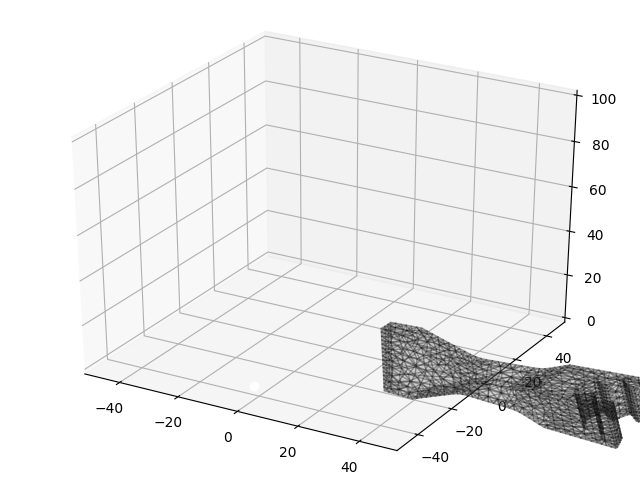

(0, 100)

In [9]:
ax2 = amfe.plot3D_submesh(disk,plot_nodes=False)
vlim=[-50,50] 
ax2.set_xlim(vlim)
ax2.set_ylim(vlim)
ax2.set_zlim(0,100)

In [10]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
rho = 7.85E-9 # ton/mm3
E = 2.10E5 # MPa = N/mm2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)
my_comp.set_domain('DISK',my_material)
print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 5750 elements and 4983 dofs.
Time taken for preallocation: 0.28 seconds.
Number of nodes is equal to 1661


In [11]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
try:
    connectivity = []
    for _,item in m.el_df.iloc[:, m.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_comp.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m.el_df)

In [12]:
K, f = my_comp.assembly_class.assemble_k_and_f()

In [13]:
M = my_comp.assembly_class.assemble_m()

In [14]:
from pyfeti.src.linalg import Matrix
K_obj = Matrix(K,key_dict=s.selection_dict)
M_obj = Matrix(M,key_dict=s.selection_dict)

In [15]:
K_obj.eliminate_by_identity('SHAFT_FACE_ELSET',1.0E15)
M_obj.eliminate_by_identity('SHAFT_FACE_ELSET',0.0)

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


<4983x4983 sparse matrix of type '<class 'numpy.float64'>'
	with 163404 stored elements in Compressed Sparse Row format>

In [16]:
from scipy import sparse

lu = sparse.linalg.splu(K_obj.data.tocsc())
D = sparse.linalg.LinearOperator(shape=K.shape,matvec=lambda x :lu.solve(M_obj.data.dot(x)))
eigval, eigvec = sparse.linalg.eigs(D,k=20)

In [17]:
eigval.real

array([2.44594647e-08, 7.47807055e-09, 8.37007092e-10, 3.33310594e-10,
       2.03016207e-10, 1.44860079e-10, 9.75531987e-11, 5.83130514e-11,
       4.02987042e-11, 3.48870497e-11, 2.80218626e-11, 2.78633605e-11,
       2.51711051e-11, 1.61768156e-11, 1.21902330e-11, 1.15635940e-11,
       1.00100570e-11, 8.00327950e-12, 7.06003513e-12, 6.58926775e-12])

In [18]:
omega = 1.0/np.sqrt(eigval.real)
print(omega)

f = omega/(2.0*np.pi)

[  6394.05733189  11563.92379334  34564.91005391  54774.12410571
  70183.43906974  83085.57710792 101246.31905341 130953.50179039
 157526.80298415 169304.25705942 188908.50045062 189445.04618521
 199319.07285755 248629.97283519 286413.83767425 294071.93719945
 316068.87018618 353480.94556576 376354.02839727 389566.33755556]


In [19]:
np.sort(eigval.real)

array([6.58926775e-12, 7.06003513e-12, 8.00327950e-12, 1.00100570e-11,
       1.15635940e-11, 1.21902330e-11, 1.61768156e-11, 2.51711051e-11,
       2.78633605e-11, 2.80218626e-11, 3.48870497e-11, 4.02987042e-11,
       5.83130514e-11, 9.75531987e-11, 1.44860079e-10, 2.03016207e-10,
       3.33310594e-10, 8.37007092e-10, 7.47807055e-09, 2.44594647e-08])

In [20]:
print(f)

[ 1017.64583078  1840.45563325  5501.17629261  8717.57260495
 11170.04125114 13223.48029637 16113.85214721 20841.89712513
 25071.16936439 26945.60939751 30065.72163879 30151.11554465
 31722.61569777 39570.68917752 45584.17803578 46803.0024299
 50303.9230476  56258.23977559 59898.60397197 62001.40828417]


In [21]:
ansys_freq = np.array([993.32,1796.7,5392.5,8521.9,10919,12907,15784,20423,24578,26363,29557,29755,31177,38950,44678,45863,49261,55703,59366,60943])

<IPython.core.display.Javascript object>


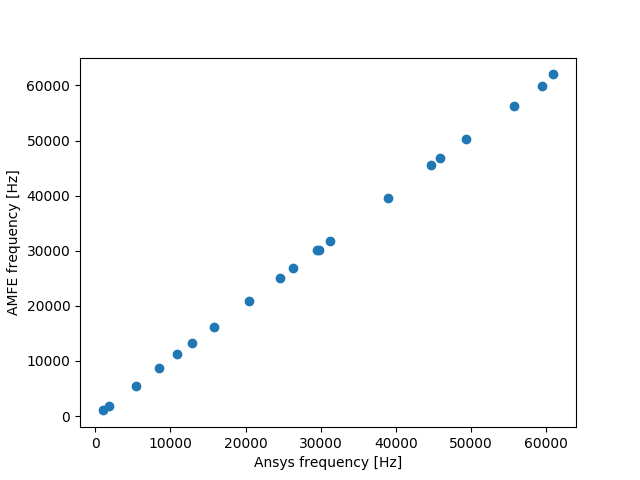

In [22]:
plt.figure()
plt.plot(ansys_freq,f,'o')
plt.xlabel('Ansys frequency [Hz]')
plt.ylabel('AMFE frequency [Hz]')
plt.show()

In [23]:
my_comp.u_output = eigvec.T.real

<IPython.core.display.Javascript object>


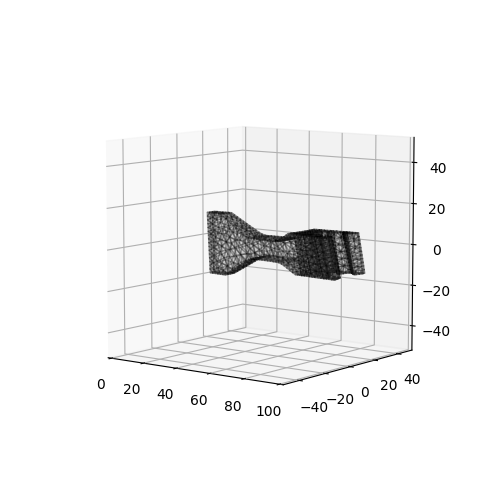

In [26]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

from pyfeti import utils
m1 = utils.load_object('disk.pkl')
fig1 = plt.figure(figsize=(5,5))
ax2 = fig1.add_subplot(1,1,1, projection='3d')
ax2.set_xlim([0,100])
ax2.set_ylim([-50,50])
ax2.set_zlim([-50,50])

def update(i=0):
    f = 1000*np.sin(i*2*np.pi)
    amfe.plot_deform_3D_mesh(m1,eigvec.T.real[0],factor=f,ax=ax2,plot_nodes=False)
    ax2.set_xlim([0,100])
    ax2.set_ylim([-50,50])
    ax2.set_zlim([-50,50])
    return ax2


#ani = FuncAnimation(fig1, update, frames=np.linspace(0, 1 ,10), blit=True, interval=1)  

update(1)

In [25]:
np.sin(1*2*np.pi)

-2.4492935982947064e-16

In [27]:
100*np.max(np.abs(ansys_freq - f)/ansys_freq)

2.4520050853690223

In [ ]:
100*np.max(np.abs(ansys_freq - f)/ansys_freq)